## Initial hierarchical analysis

In [1]:
pip install cmdstanpy

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/jupyter-1.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Frameworks/Python.framework/Versions/3.11/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -e git+https://github.com/stan-dev/cmdstanpy@develop#egg=cmdstanpy

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/jupyter-1.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Obtaining cmdstanpy from git+https://github.com/stan-dev/cmdstanpy@develop#egg=cmdstanpy
  Updating ./src/cmdstanpy clone (to revision develop)
  Running command git fetch -q --tags
  Running command git reset --hard -q cbea79f3e2f03dfe0f056c30cb613bf30d527750
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for cmdstanpy (pyproject.toml) ... done
  Created wheel for cmdstanpy: filename=cmdstanpy-1.2.2-0.editable-py3-none-any.whl size=5411 sha256=a6

In [1]:
import cmdstanpy as csp

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

C:\Users\mirar\anaconda3\envs\stan\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_all = pd.read_csv("data_mags_5000.csv")

In [3]:
data_all.columns

Index(['template_id', 'median_z', 'mean_z', 'minchi2', 'mode_z', 'z_sigma68',
       'z_sigma', 'z_mc', 'concentration_i', 'concentration_cal_i',
       'asymmetry_i', 'clumpiness_i', 'gini_i', 'm20_i', 'mag_sersic_i',
       'mag_cal_i', 're_sersic_i', 're_cal_i', 'n_sersic_i', 'n_sersic_cal_i',
       'ellipticity_sersic_i', 'ellipticity_sersic_cal_i'],
      dtype='object')

In [32]:
N = data_all.shape[0]
# log_minchi2 = np.log(data_all["minchi2"])
median_z = data_all["median_z"]
z_sigma68 = data_all["z_sigma68"]
group_id = data_all["template_id"] + 1 # + 1 since python and stan use different indices
num_templates = len(np.unique(group_id))

a1 = 1
b1 = 1
a2 = 1
b2 = 1
nu = 3
lambda_var = 1

In [33]:
print(num_templates)

42


In [34]:
print(np.min(group_id))
print(np.max(group_id))

1
44


In [35]:
data = {'N': N, 
        'J': num_templates,
        'm': np.max(group_id), 
        'z_sigma': z_sigma68,
        'median_z': median_z,
        'group_id': group_id,
        'a1': a1,
        'b1': b1,
        'a2': a2,
        'b2': b2,
        'nu': nu,
        'lambda': lambda_var,}

In [12]:
from cmdstanpy import install_cmdstan
install_cmdstan(verbose=True)

Cannot connect to github.
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>
retry (1/5)
Cannot connect to github.
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>
retry (2/5)
Cannot connect to github.
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>
retry (3/5)
Cannot connect to github.
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>
retry (4/5)
Cannot connect to github.
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>
retry (5/5)


13:18:49 - cmdstanpy - WARNING - CmdStan installation failed.
Cannot connect to CmdStan github repo.


Cannot connect to github.
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>


False

In [36]:
model = csp.CmdStanModel(stan_file = 'hierarchical-regression.stan')
sample = model.sample(data = data, seed = 1, chains = 1,
                      iter_sampling = 5000, iter_warmup = 5000,
                      show_progress = False, show_console = False)

18:57:26 - cmdstanpy - INFO - CmdStan start processing
18:57:26 - cmdstanpy - INFO - Chain [1] start processing
19:00:23 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# how to save a model
sample.save_csvfiles("second-run-sigma68/model-data-50000-prior1")

# how to read a saved file
#sample = csp.from_csv("model-data-cut-5000/hierarchical-regression-20240422121707.csv")

In [37]:
alpha_list = sample.stan_variable("alpha")
beta_list = sample.stan_variable("beta")

In [38]:
print(alpha_list.shape)

(5000, 44)


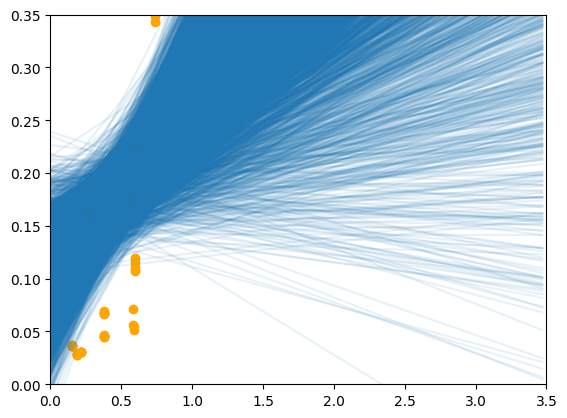

In [13]:
group_index = 41

zs = np.arange(0, np.max(median_z), np.max(median_z)/1000)
segs = []
for i in range(alpha_list.shape[0]):
    data = alpha_list[i][group_index] + beta_list[i][group_index]*zs
    segs.append(((zs[0], data[0]), (zs[-1], data[-1])))

# get first group of data
group1_sigma = np.array(z_sigma68)[np.where(group_id==group_index)]
group1_z = np.array(median_z)[np.where(group_id==group_index)]

# plot the group data

ln_coll = matplotlib.collections.LineCollection(segs, alpha=0.1)
ax = plt.gca()
ax2 = plt.scatter(group1_z, group1_sigma, color='orange')
ax.add_collection(ln_coll)
ax.set_xlim(0, 3.5)    
ax.set_ylim(0.0, 0.35)
plt.draw()

### Plotting by template type
Group raw data by template ID and assign a color.

Make a line collection of all alphas and betas from each template group. Add in alpha_bar and beta_bar for a global linear fit.

In [39]:
alpha_group = np.array([np.mean(alpha_template) for alpha_template in sample.stan_variable("alpha").transpose()])
beta_group = np.array([np.mean(beta_template) for beta_template in sample.stan_variable("beta").transpose()])
color_map = np.arange(0, data_all["template_id"].max()+1)

In [40]:
# get the global slope and intercept
alpha_bar = np.mean(sample.stan_variable('alpha_bar'))
beta_bar = np.mean(sample.stan_variable('beta_bar'))
print(alpha_bar, beta_bar)

0.07819251668 -0.010686044997214001


In [41]:
x_data = median_z
y_data = z_sigma68

In [42]:
xs = np.arange(np.min(x_data), np.max(x_data), np.max(x_data)/1000) # replace median_z with whatever x-axis is
segs = []
for template_id in range(len(alpha_group)):
    data = alpha_group[template_id] + beta_group[template_id]*xs
    segs.append(((xs[0], data[0]), (xs[-1], data[-1])))

# append the global linear fit
global_seg = []
global_data = alpha_bar + beta_bar*xs
global_seg.append(((xs[0], global_data[0]), (xs[-1], global_data[-1])))

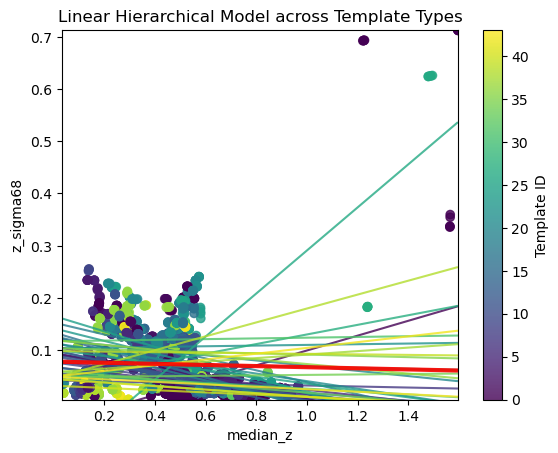

In [43]:
fig, ax = plt.subplots()
ln_coll = matplotlib.collections.LineCollection(segs, array=color_map, alpha=0.8, linewidths=1.5)
global_ln_coll = matplotlib.collections.LineCollection(global_seg, color='red', alpha=0.9, linewidths=3)

ax.set_xlim(np.min(x_data), np.max(x_data))    
ax.set_ylim(np.min(z_sigma68), np.max(y_data))
ax.set_xlabel("median_z")
ax.set_ylabel("z_sigma68")
ax.set_title("Linear Hierarchical Model across Template Types")

ax.add_collection(ln_coll)
ax.add_collection(global_ln_coll)
ax.scatter(x_data, z_sigma68, c=group_id, alpha=0.8)

template_color = fig.colorbar(ln_coll)
template_color.set_label('Template ID')
plt.show()

## Introducing magnitudes

In [20]:
data_mags = pd.read_csv("data_mags_50000.csv")

In [21]:
data_mags.columns

Index(['template_id', 'median_z', 'mean_z', 'minchi2', 'mode_z', 'z_sigma68',
       'z_sigma', 'z_mc', 'concentration_i', 'concentration_cal_i',
       'asymmetry_i', 'clumpiness_i', 'gini_i', 'm20_i', 'mag_sersic_i',
       'mag_cal_i', 're_sersic_i', 're_cal_i', 'n_sersic_i', 'n_sersic_cal_i',
       'ellipticity_sersic_i', 'ellipticity_sersic_cal_i'],
      dtype='object')

In [26]:
median_z = data_mags["median_z"]
mag_sersic = data_mags["mag_sersic_i"]
mag_cal = data_mags["mag_cal_i"]

concentration_i = data_mags['concentration_i']
asymmetry_i = data_mags['asymmetry_i']
concentration_i = data_mags['concentration_i']
clumpiness_i = data_mags['clumpiness_i']
gini_i = data_mags['gini_i']
m20_i = data_mags['m20_i']
re_sersic_i = data_mags['re_sersic_i']
concentration_i = data_mags['concentration_i']

In [23]:
mag_ratio = np.abs(mag_cal) / mag_sersic

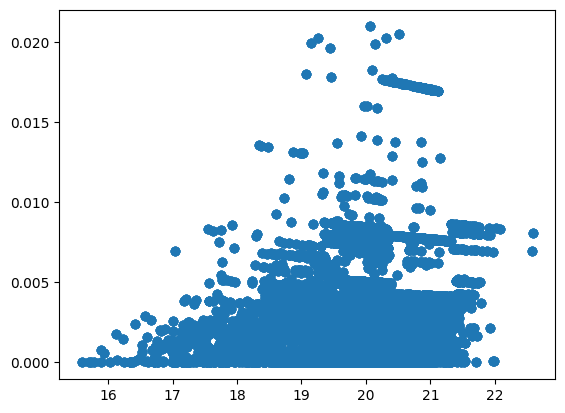

In [24]:
plt.scatter(mag_sersic, mag_ratio)

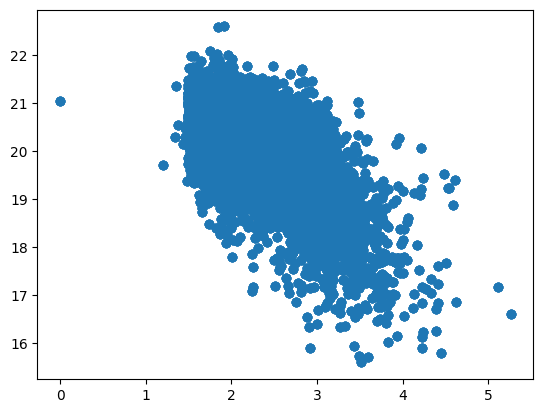

In [32]:
plt.scatter(concentration_i, mag_sersic)

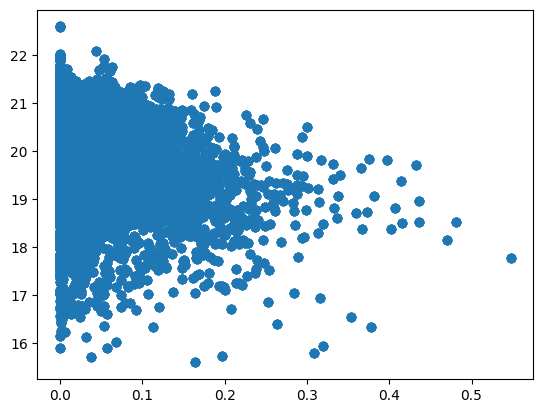

In [31]:
plt.scatter(clumpiness_i, mag_sersic)

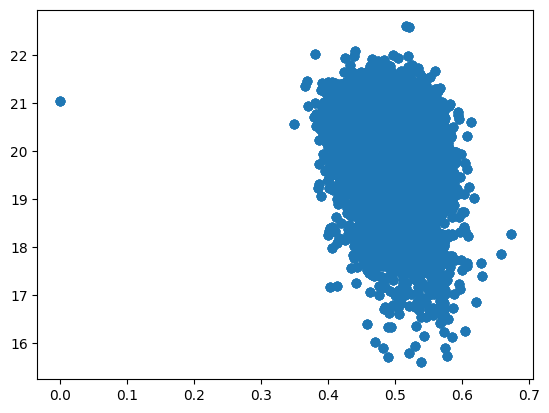

In [30]:
plt.scatter(gini_i, mag_sersic)

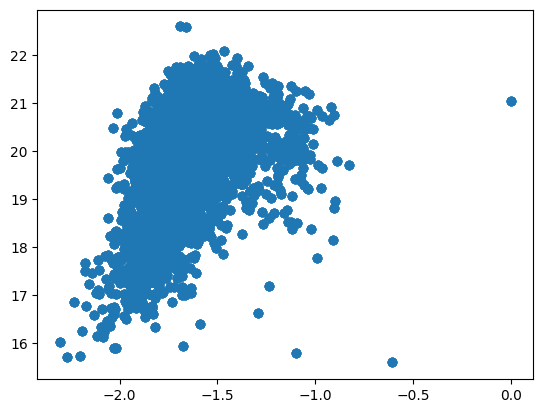

In [33]:
plt.scatter(m20_i, mag_sersic)

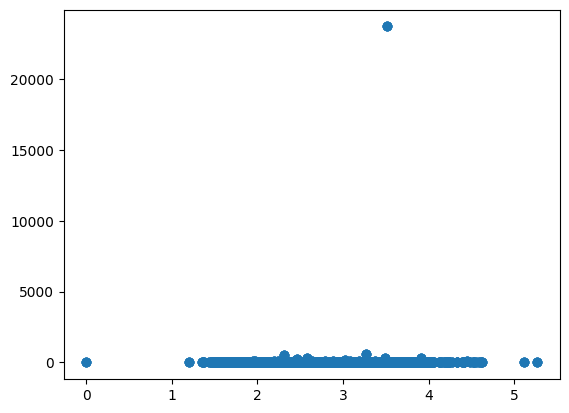

In [34]:
plt.scatter(concentration_i, re_sersic_i)

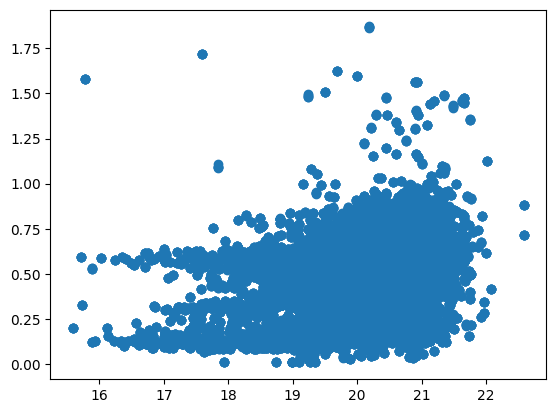

In [35]:
plt.scatter(mag_sersic, median_z)